In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# parámetros “hardware” de ejemplo
L    = 200e-6      # inductancia del filtro (H)
V_DC = 150.0       # bus continuo disponible (V)
Ts   = 100e-6      # periodo de muestreo del lazo PI (s)  → 10 kHz
N_C  = 40          # nº de celdas en el stack (solo para estimar V_stack)
V_CELL_EST = 1.9   # V/celda aprox. en punto nominal


In [4]:
@dataclass
class PIParams:
    Kp: float    # [Ω]  Proporcional
    Ki: float    # [Ω/s]  Integral (ganancia * frecuencia)
    Ts: float    # [s]   periodo de muestreo
    Vdc: float   # [V]   tensión del bus DC

class CurrentPI:
    """PI digital con anti-wind-up (back-calculation sencillo)."""
    def __init__(self, p: PIParams):
        self.p = p
        self.i_int = 0.0

    def update(self, i_ref: float, i_meas: float) -> float:
        e    = i_ref - i_meas
        u_p  = self.p.Kp * e
        self.i_int += self.p.Ki * self.p.Ts * e        # integrador

        u = u_p + self.i_int                           # tensión ideal
        d = np.clip(u / self.p.Vdc, 0.0, 1.0)          # ciclo de trabajo

        # anti-wind-up: si saturó, “des-integra” lo recién sumado
        if u != self.p.Vdc * d:
            self.i_int -= self.p.Ki * self.p.Ts * e

        return d


In [5]:
# parámetros del PI
params = PIParams(Kp=0.63, Ki=990, Ts=Ts, Vdc=V_DC)
pi     = CurrentPI(params)

# escenario: escalón de 0 → 40 A durante 5 ms
I_ref = 40.0
sim_time = 0.005        # [s]
steps    = int(sim_time / Ts)

I      = 0.0            # corriente inicial
I_log  = np.empty(steps)
duty   = 0.0

for k in range(steps):
    duty = pi.update(I_ref, I)

    # “planta” DC/DC + stack (modelo ultrarreducido)
    V_stack = N_C * V_CELL_EST                # suponemos tensión casi fija
    dI_dt   = (V_DC * duty - V_stack) / L     # ecuación dI/dt
    I      += dI_dt * Ts

    I_log[k] = I

time = np.linspace(0, sim_time, steps)


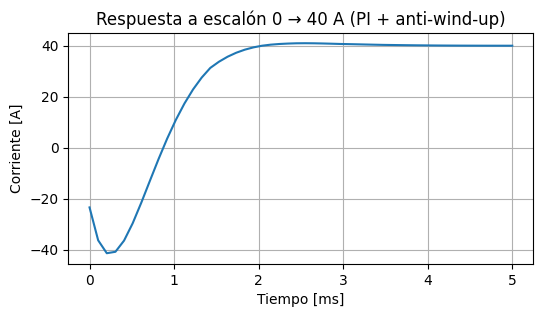

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(time * 1e3, I_log)      # tiempo en ms
plt.xlabel("Tiempo [ms]")
plt.ylabel("Corriente [A]")
plt.title("Respuesta a escalón 0 → 40 A (PI + anti-wind-up)")
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ---------- hardware del convertidor (Nivel 1) ----------
L        = 200e-6          # H  inductor
V_DC     = 150.0           # V  bus DC
Ts_fast  = 100e-6          # s  (10 kHz)

# ---------- stack (estimación simple) ----------
N        = 40              # nº de celdas
V0_cell  = 1.90            # V  a I≈0 A
r_cell   = 0.0013          # Ω (1.3 mΩ) pendiente polarización
R_ext    = 0.015           # Ω cables + bornes

# ---------- térmico lumped ----------
C_th = 4_000               # J/K   (stack + placas)
R_th = 0.2                 # K/W
T_amb = 298.15             # K  (25 °C)

# ---------- PI de corriente ORIGINAL (con pico negativo) ----------
@dataclass
class PI1: Kp: float; Ki: float; Ts: float; Vdc: float
class FastPI:
    def __init__(self,p): self.p,self.i = p,0.0
    def update(self,ref,meas):
        e = ref-meas
        self.i += self.p.Ki*self.p.Ts*e
        u = self.p.Kp*e + self.i
        d = np.clip(u/self.p.Vdc,0,1)
        if u!=self.p.Vdc*d:                   # anti-wind-up
            self.i -= self.p.Ki*self.p.Ts*e
        return d

pi_fast = FastPI(PI1(Kp=0.63, Ki=990, Ts=Ts_fast, Vdc=V_DC))

# ---------- parámetros de Nivel 2 ----------
Ts_slow = 0.1              # s    (10 Hz)
I_max   = 80.0             # A
dI_max  = 20.0             # A/s
T_set   = 323.15           # K  (50 °C)
Kp_T, Ki_T = 14, 0.003    # ganancias temperatura
I_int_T = 0.0

# ---------- perfil de potencia renovable 0→4 kW --------------
P_profile = np.concatenate([
    np.linspace(0,2000,200), np.full(200,2000),
    np.linspace(2000,4000,200)])
def P_ren(t):                              # t en s
    idx = min(int(t/Ts_slow), len(P_profile)-1)
    return P_profile[idx]


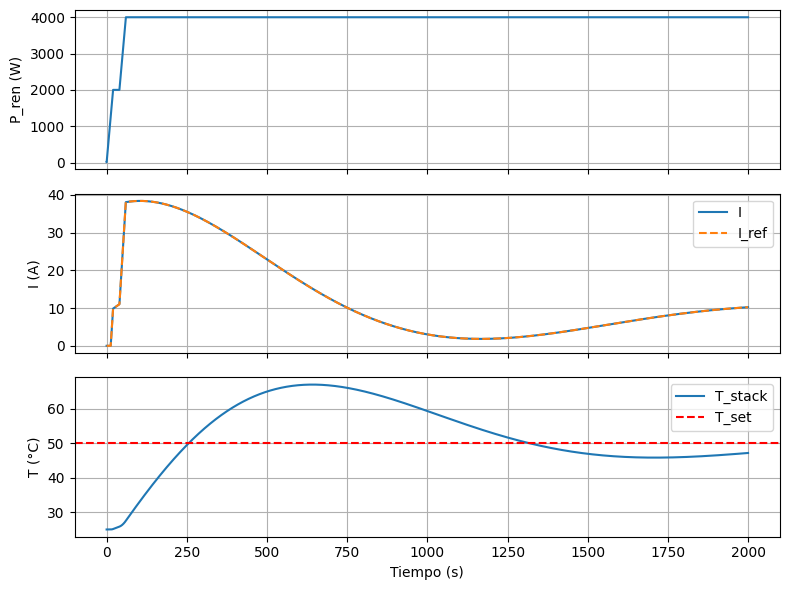

In [46]:
# ---------- estado inicial ----------
I, T_stack, I_ref_fast = 0.0, T_amb, 0.0
t_end, t, nxt_slow = 2000.0, 0.0, Ts_slow
log_t, log_I, log_Iref, log_T, log_P = [],[],[],[],[]

# ---------- bucle doble ----------
while t < t_end:
    # ---- Nivel 1 (100 µs) ----
    duty = pi_fast.update(I_ref_fast, I)
    V_stack = N*(V0_cell + r_cell*I) + R_ext*I
    dI_dt   = (V_DC*duty - V_stack)/L
    if I<=0 and dI_dt<0:                      # diodo ideal
        dI_dt = 0.0
    I += dI_dt*Ts_fast

    # ---- Nivel 2 (cada 0.1 s) ----
    if t >= nxt_slow-1e-12:
        nxt_slow += Ts_slow
        # feed-forward potencia
        P = P_ren(t)
        V_est = N*(V0_cell)                   # 1.9·40 = 76 V
        I_FF  = np.clip(P/V_est, 0, I_max)

        # PI temperatura
        eT = T_set - T_stack
        I_int_T += Ki_T*Ts_slow*eT
        dI_T = Kp_T*eT + I_int_T

        # referencia rápida con rampas
        I_target = np.clip(I_FF + dI_T, 0, I_max)
        delta_I  = np.clip(I_target-I_ref_fast,
                           -dI_max*Ts_slow, dI_max*Ts_slow)
        I_ref_fast += delta_I

        # térmica lumped
        P_loss = 0.18 * (V_stack*I)           # 18 % de P_el
        dTdt   = (P_loss - (T_stack-T_amb)/R_th)/C_th
        T_stack += dTdt*Ts_slow

        # log
        log_t.append(t); log_I.append(I); log_Iref.append(I_ref_fast)
        log_T.append(T_stack-273.15); log_P.append(P)

    t += Ts_fast

# ---------- gráficas ----------
fig, ax = plt.subplots(3,1, figsize=(8,6), sharex=True)
ax[0].plot(log_t, log_P);              ax[0].set_ylabel('P_ren (W)'); ax[0].grid()
ax[1].plot(log_t, log_I, label='I');   ax[1].plot(log_t, log_Iref,'--',label='I_ref')
ax[1].set_ylabel('I (A)'); ax[1].legend(); ax[1].grid()
ax[2].plot(log_t, log_T, label='T_stack'); ax[2].axhline(T_set-273.15,color='r',ls='--',label='T_set')
ax[2].set_ylabel('T (°C)'); ax[2].set_xlabel('Tiempo (s)'); ax[2].legend(); ax[2].grid()
plt.tight_layout(); plt.show()


In [5]:
import numpy as np
import cvxpy as cp
import matplotlib
matplotlib.use('TkAgg')  # o 'Qt5Agg'
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from dataclasses import dataclass

# ------------------------------------------------------------------
# Parámetros generales de simulación
# ------------------------------------------------------------------
SIM_SCALE = 3600.0 / 100.0   # 1 s sim = 36 s real (100 s sim = 1 h real)

# 0) Perfil solar 24 h → 2400 s sim
hours     = np.arange(24)
irr_Wm2   = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   42.10, 118.35, 205.80, 295.40, 352.25, 381.60,
   372.45, 340.10, 258.75, 176.30, 88.40, 15.20,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0
], dtype=float)
irr_norm  = irr_Wm2 / 1000.0
P_day     = 10000.0 * irr_norm             # W pico 10 kW
T_END     = 2400.0                         # s sim (24 h)
Ts_slow   = 0.1                            # s sim

t_slow    = np.arange(0, T_END+Ts_slow, Ts_slow)
P_FV      = np.interp(t_slow/100.0, hours, P_day)
Irr_s     = np.interp(t_slow/100.0, hours, irr_norm)

# 1) Nivel 1 – PI corriente (100 kHz → Ts_fast=100µs)
L, VDC, Ts_fast = 200e-6, 150.0, 100e-6
N, V_CELL       = 60, 1.90

@dataclass
class PI1:
    Kp: float; Ki: float; Ts: float; Vdc: float

class FastPI:
    def __init__(self, p): 
        self.p, self.i = p, 0.0
    def update(self, ref, meas):
        e = ref - meas
        self.i += self.p.Ki * self.p.Ts * e
        u = self.p.Kp*e + self.i
        d = np.clip(u/self.p.Vdc, 0.0, 1.0)
        if u != self.p.Vdc*d:  # anti-windup
            self.i -= self.p.Ki * self.p.Ts * e
        return d

pi_fast = FastPI(PI1(0.63, 990.0, Ts_fast, VDC))

# 2) Nivel 2 – Térmico lumped + PI temperatura
C_th, R_th_pass, R_th_cool = 1500.0, 0.50, 0.12
T_amb, T_set, T_crit       = 298.15, 328.15, 338.15
Kp_T, Ki_T                 = 1.2, 0.003
I_int_T, I_int_clamp       = 0.0, 40.0
I_min_hw, I_max_hw, dI_max = 0.0, 95.0, 25.0

# 3) Nivel 3 – MPC supervisor (4 s sim)
Ts_sup = 4.0
H      = 10
# Parámetros dinámicos térmicos
R_th, C = R_th_pass, C_th
a      = 1 - Ts_sup/(R_th*C)
b      = Ts_sup*(0.17*N*V_CELL)/C

# Parámetros H2
i_F = 96485.0
R_Nm3   = 22.414e-3
KG_Nm3  = 0.08988
alpha   = (R_Nm3*KG_Nm3)/(2*i_F)  # kg/(A·s)

# CVXPY setup
I_var    = cp.Variable(H)
T_var    = cp.Variable(H+1)
P_par    = cp.Parameter(H, nonneg=True)
T0_par   = cp.Parameter(nonneg=True)
constraints = [T_var[0] == T0_par]
for k in range(H):
    constraints += [
        I_var[k] >= 0.0, I_var[k] <= I_max_hw,
        N*V_CELL*I_var[k] <= P_par[k],
        T_var[k+1] == a*T_var[k] + b*I_var[k],
        T_var[k+1] <= T_crit
    ]
objective = cp.Maximize(cp.sum(alpha*I_var*Ts_sup))
prob = cp.Problem(objective, constraints)

def solve_mpc(P_slice, T_now):
    P_par.value  = P_slice
    T0_par.value = T_now
    for solver in ('ECOS','OSQP','SCS'):
        try:
            prob.solve(solver=solver, warm_start=True, verbose=False)
            if I_var.value is not None:
                return float(I_var.value[0])
        except:
            pass
    return 0.0

# 4) Simulación offline y logs
t_points  = len(t_slow)
sub_steps = int(Ts_slow / Ts_fast)
steps_sup = int(Ts_sup / Ts_slow)

I           = 0.0
I_ref_fast  = P_FV[0]/(N*V_CELL)
T_stack     = T_amb
H2_tot_kg   = 0.0

I_log       = np.zeros(t_points)
Ir_log      = np.zeros(t_points)
T_log       = np.zeros(t_points)
H2i_log_g   = np.zeros(t_points)
H2tot_log_g = np.zeros(t_points)

for k in range(t_points):
    # MPC supervisor cada Ts_sup
    if k % steps_sup == 0:
        P_slice = P_FV[k:k+H]
        if len(P_slice) < H:
            P_slice = np.pad(P_slice, (0, H-len(P_slice)), 'edge')
        I_max_sup = solve_mpc(P_slice, T_stack)

    # Sub-pasos de corriente
    for _ in range(sub_steps):
        duty = pi_fast.update(I_ref_fast, I)
        V_stk= N*V_CELL
        dI   = (VDC*duty - V_stk)/L
        if I <= 0 and dI < 0:
            dI = 0.0
        I += dI * Ts_fast
        # Acumulación real de H2
        H2_tot_kg += I * alpha * (Ts_fast * SIM_SCALE)

    # PI térmico
    eT = T_set - T_stack
    if abs(eT) < 1.0:
        I_int_T = np.clip(I_int_T + Ki_T*Ts_slow*eT, -I_int_clamp, I_int_clamp)
    dI_T      = Kp_T*eT + I_int_T
    I_target  = np.clip(I_max_sup + dI_T, I_min_hw, I_max_sup)
    delta     = np.clip(I_target - I_ref_fast, -dI_max*Ts_slow, dI_max*Ts_slow)
    I_ref_fast+= delta
    if T_stack < T_set - 1.0:
        I_int_T = 0.0

    # Modelo térmico RC
    P_loss = 0.0 if I < 1e-3 else 0.17 * V_stk * I
    R_eff  = R_th_cool if T_stack > T_set + 1.0 else R_th_pass
    dT     = (P_loss - (T_stack - T_amb)/R_eff) / C_th
    T_stack+= dT * Ts_slow

    # Logging
    I_log[k]    = I
    Ir_log[k]   = I_ref_fast
    T_log[k]    = T_stack - 273.15
    H2i_rate_kgph = I * alpha * 3600.0
    H2i_log_g[k]   = H2i_rate_kgph * 1000.0
    H2tot_log_g[k] = H2_tot_kg * 1000.0

# 5) Gráficos estáticos
fig, (axI, axT, axH) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Corriente, referencia, potencia e irradiancia
axI.plot(t_slow, I_log, 'b', label='I [A]')
axI.plot(t_slow, Ir_log, '--', label='I_ref [A]')
axI.set_ylabel('Corriente [A]')
axI.grid(True)
axI2 = axI.twinx()
axI2.plot(t_slow, P_FV/1000.0, 'k-', alpha=0.6, label='P_FV [kW]')
axI2.plot(t_slow,
          Irr_s, 'k:', alpha=0.8, label='Irradiancia [p.u.]')
axI2.set_ylabel('P_FV [kW] / Irrad.')

# Temperatura
axT.plot(t_slow, T_log, 'r', label='T_stack [°C]')
axT.axhline(T_set-273.15, ls='--', label='T_set')
axT.axhline(T_crit-273.15, ls=':', label='T_crit')
axT.set_ylabel('Temperatura [°C]')
axT.grid(True)
axT.legend()

# H2 en gramos
axHl = axH
axHr = axH.twinx()
axHl.plot(t_slow, H2i_log_g, 'g', label='H2 inst [g/h]')
axHr.plot(t_slow, H2tot_log_g, 'olive', label='H2 acum [g]')
axHl.set_ylabel('Producción [g/h]')
axHr.set_ylabel('Acumulado [g]')
for ax in (axHl, axHr):
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(True)
axHl.grid(True)
axHl.legend(loc='upper left')

axH.set_xlabel('Tiempo [s sim]')
plt.tight_layout()
plt.show()
_

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


999

In [ ]:
# ---------- Estilo general IEEE friendly ----------
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,                 # texto legible en doble columna (≈8 pt)
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "lines.linewidth": 1.2,
    "legend.frameon": False,
})

# ---------- Creación de la figura ----------
fig, (axI, axT, axH) = plt.subplots(
    3, 1, figsize=(6.7, 6.4), sharex=True,
    gridspec_kw={"hspace": 0.35})   # 6.7 in ≈ ancho columna IEEE

# --- (1) Corriente & Potencia FV ---
axI.plot(t_slow/3600, I_log,  color="#2166ac", label=r"$I$ (A)")
axI.plot(t_slow/3600, Ir_log, ls="--", color="#67a9cf", label=r"$I_{\mathrm{ref}}$ (A)")
axI.set_ylabel("Current (A)")
axI_twin = axI.twinx()
axI_twin.plot(t_slow/3600, P_FV/1e3,  color="#b2182b", label="PV power (kW)")
axI_twin.plot(t_slow/3600, Irr_s, ls=":", color="#ef8a62", label="Irradiance (p.u.)")
axI_twin.set_ylabel("PV power (kW) / Irradiance (p.u.)")

# Unir leyendas de ambos ejes
lines = axI.get_lines() + axI_twin.get_lines()
labels = [l.get_label() for l in lines]
axI.legend(lines, labels, loc="upper left", ncol=2)

# --- (2) Temperatura ---
axT.plot(t_slow/3600, T_log, color="#d6604d", label=r"$T_{\mathrm{stack}}$ (°C)")
axT.axhline((T_set-273.15), ls="--", color="#4d9221", label=r"$T_{\mathrm{set}}$")
axT.axhline((T_crit-273.15), ls=":",  color="#c51b7d", label=r"$T_{\mathrm{crit}}$")
axT.set_ylabel("Temperature (°C)")
axT.legend(loc="upper left", ncol=3)

# --- (3) Hidrógeno ---
axHl = axH
axHr = axH.twinx()
axHl.plot(t_slow/3600, H2i_log_g, color="#238b45", label="Inst. H$_2$ (g/h)")
axHr.plot(t_slow/3600, H2tot_log_g, color="#006d2c", label="Cumulative (g)")
axHl.set_ylabel("H$_2$ rate (g h$^{-1}$)")
axHr.set_ylabel("Cumulative H$_2$ (g)")

# Formato científico limpio
for ax in (axHl, axHr):
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 3))

# Combinar leyendas de ambos ejes en (3)
linesH = axHl.get_lines() + axHr.get_lines()
labelsH = [l.get_label() for l in linesH]
axHl.legend(linesH, labelsH, loc="upper left")

# Eje X común (horas de simulación)
axH.set_xlabel("Simulation time (h)")

# Letras (a)–(c) para referenciar en el texto
for idx, axis in enumerate([axI, axT, axH], start=1):
    axis.text(-0.06, 1.05, f"({chr(96+idx)})", transform=axis.transAxes,
              fontsize=8, fontweight="bold", va="bottom")

plt.tight_layout()

# ---------- Guardar en formatos de alta resolución ----------
plt.savefig("fig_results_PEM_PV.png", dpi=600)
plt.savefig("fig_results_PEM_PV.pdf")   # vectorial para LaTeX
plt.show()
